# PREDIÇÃO DA RECEITA DE UM FILME


## PROPOSTA

Neste projeto, a proposta é prever a receita de um filme, a partir de uma analise de um Modelo de Regressão Simples, que faz uso principalmente de um resultado de regressão linear entre duas variáveis quantitativas.

Importando as bibliotecas que serão utilizadas:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from datetime import datetime
from ast import literal_eval
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import OneHotEncoder
from encode_json_column import encode_json_column #def link https://github.com/rian-van-den-ander/explorations/blob/cbe2c13ea1ecb0a5f00e7e241cbf3e6f2e9492b7/film_success/encode_json_column.py#L28

Lendo nosso dataset csv e armazenando na variável "metadados" que será utlizada:

In [2]:
metadados = pd.read_csv('movies_metadata.csv')
metadados.head(3)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


Ao ser convertida, a coluna 'id' ficou com o formato de obj. Para poder filtrar o nosso dataset apenas com os filmes que estao no dataset small_links, precisamos transformar essa coluna no formato de 'int'. 


**obs**: Para transformar em 'int' foi preciso remover as linhas 19730,29503 e 35587, pois não estavam de acordo com a padrao da coluna.

In [3]:
metadados = metadados.drop([19730, 29503, 35587])
metadados['id'] = metadados['id'].astype('int')

In [4]:
metadados['budget'] = metadados['budget'].astype('int')

Lendo smd; nosso dataset só com as variáveis que selecionamos do original:

In [5]:
metadados.describe()

,budget,id,revenue,runtime,vote_average,vote_count
count,4.546300e+04,45463.000000,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,4.224579e+06,108359.918813,1.120935e+07,94.128199,5.618207,109.897338
std,1.742413e+07,112460.749278,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,2.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,26449.500000,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,60003.000000,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,157328.000000,0.000000e+00,107.000000,6.800000,34.000000
max,3.800000e+08,469172.000000,2.787965e+09,1256.000000,10.000000,14075.000000


In [6]:
metadados.dtypes

adult                     object
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [7]:
#mu = rs.revenue.mean()
#x = np.linspace(0,10**9,100000)
#y = stats.expon.pdf(x, scale=mu)
#plt.plot(x, y, color='r')
#rs.revenue.plot.hist(density = True, bins = 100)
#plt.ylabel('densidade')
#plt.xlabel('valores de x')
#plt.title('Função densidade de probabilidade')
#plt.show()

A partir dos gráficos acima, observa-se que a variável revenue distribui-se de forma similar a uma exponencial

## Modelo de Regressao simples

O nosso objetivo em um primeiro momento é prever a receita de um filme em função do seu orcamento, a partir do modelo de regressao linear simples. Neste caso sao definidas como variáveis:


* ***y -*** **Variável independente (explicativa)**: Budget
* ***x -*** **Variável dependente (target)**: Revenue
 

### Teste de hipótese e suposicoes do modelo

Para avaliar a significancia da regressao vamos realizar um teste de hipotes. Assumindo que:

* H0: β1 = 0 - nao ha relacao entre receita e orcamento
* HA: β1 ≠ 0 - há relacao entre receita e orcamento


Para realizar o teste de hipóteses é necessário analisar a distribuicao dos erros, além das seguintes suposicoes do modelo:

* Os erros têm distribuição normal com média e variânciaconstante, ou seja, ei ~ N(0,s2).
* Os erros são independentes entre si, ou seja, Corr(ei , ej) = 0, para qualquer i ≠ j.
* O modelo é linear nos parâmetros.
* Homocedasticidade: Var(ei) = s2 para qualquer i


In [8]:
rs = metadados[['title', 'budget', 'revenue']].set_index('title')
rs.describe()

,budget,revenue
count,4.546300e+04,4.546000e+04
mean,4.224579e+06,1.120935e+07
std,1.742413e+07,6.433225e+07
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,3.800000e+08,2.787965e+09


Ao analisar o describe das duas variaveis , é possivel observar que mais de 75% (38052 filmes) dos dados tem valores iguais a zero, possivelmente indica uma falta de dados. Como isso nao é bom para nossa análise, vamos fazer uma limpeza nos dados

In [9]:
rs[rs['revenue'] == 0].shape

(38052, 2)

In [10]:
rs.shape

(45463, 2)

In [11]:
rs['revenue'] = rs['revenue'].replace(0, np.nan)
rs['budget'] = rs['budget'].replace(0, np.nan)
rs = rs[['budget','revenue']].dropna()

rs.shape

(5381, 2)

In [12]:
rs.describe()

,budget,revenue
count,5.381000e+03,5.381000e+03
mean,3.109480e+07,9.031812e+07
std,4.016263e+07,1.661423e+08
min,1.000000e+00,1.000000e+00
25%,5.037000e+06,7.011317e+06
50%,1.700000e+07,2.991874e+07
75%,4.000000e+07,9.996575e+07
max,3.800000e+08,2.787965e+09


Feita a limpeza, o que nos resta sao dados de 5381 filmes, que corresponde a cerca de 11% do nosso dataframe original, o que ainda é um conjunto considerável de dados. A partir deste novo conjunto de dados, vamos fazer um gráfico de dispercao com as duas variaveis para realizar uma primeira análise:

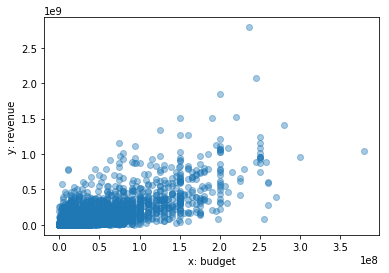

In [13]:
x_dados = rs.budget # Definindo budget como explicativa
y_dados = rs.revenue   # Definindo revenue como resposta

plt.scatter(x_dados,y_dados, alpha=0.4);
plt.xlabel("x: budget");
plt.ylabel("y: revenue");

A partir do gráfico acima, observa-se que uma reta pode ser um bom ajuste neste caso. Seguindo a diante em nosso modelo de regressao, vamos utilizar a funcao OLS da biblioteca ststsmodel, para definir os valore de beta1 e beta0, baseado no método dos mínimos quadrados.

In [14]:
# Matriz de 1s e valores de x_dados
X_dados = sm.add_constant(x_dados) # Adiciona coluna de 1s para estimar intercepto junto com a coluna de x (dados)

In [15]:
# Define o modelo
model = sm.OLS(y_dados, X_dados)    

# Faz o ajuste
results = model.fit()   

# Mostra os resultados
results.summary()     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6146.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:09:49   Log-Likelihood:            -1.0744e+05
No. Observations:                5381   AIC:                         2.149e+05
Df Residuals:                    5379   BIC:                         2.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.617e+06   1.96e+06     -1.848      0.065   -7.45e+06    2.19e+05
budget         3.0209      0.039     78.400      0.000       2.945       3.096
==============================================================================
Omnibus:                     4638.631   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357550.028
Skew:                           3.709   Prob(JB):                         0.00
Kurtosis:                      42.239   Cond. No.                     6.42e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ou poderíamos utilizar a funcao regress criada, que aguliza o process

In [16]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

results = regress(X_dados,y_dados)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6146.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:09:49   Log-Likelihood:            -1.0744e+05
No. Observations:                5381   AIC:                         2.149e+05
Df Residuals:                    5379   BIC:                         2.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.617e+06   1.96e+06     -1.848      0.065   -7.45e+06    2.19e+05
budget         3.0209      0.039     78.400      0.000       2.945       3.096
==============================================================================
Omnibus:                     4638.631   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357550.028
Skew:                           3.709   Prob(JB):                         0.00
Kurtosis:                      42.239   Cond. No.                     6.42e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Definicao de b0 e b1

Como beta1 não é igual a zero, podemos rejeitar a hipotese nula, ou seja, há uma relacao entre x e y.

In [17]:
beta0 = results.params['const']
beta1 = results.params['budget']

print("Estimativa de beta0 (coeficente linear): {0}".format(beta0))
print("Estimativa de beta1 (coeficente angular): {0}".format(beta1))

Estimativa de beta0 (coeficente linear): -3617362.4059044896
Estimativa de beta1 (coeficente angular): 3.0209391248649125


Para avaliar a significancia da regressao vamos realizar um teste de hipotes. Assumindo que:
- Se o valor p for menor que o nivel de significancia escolhido, podemos dizer que x é relevante na analise
- erros tem distribuicao normal com media e variancia constantes
- os erros sao independentes entre si corr = 0

#### Análise valor p

Definindo o nivel de significancia em 10%, temos que o valor-p é menor que alfa, logo rejeita-se H0

In [18]:
valorp_beta0 = results.pvalues['const']
valorp_beta1 = results.pvalues['budget']

print('Valor-p sob H0: beta0 = 0: {:.6f}'.format(valorp_beta0))
print('Valor-p sob H0: beta1 = 0: {:.6f}'.format(valorp_beta1))

Valor-p sob H0: beta0 = 0: 0.064606
Valor-p sob H0: beta1 = 0: 0.000000


In [19]:
#valores preditos de receita
ypredict = results.predict(X_dados).to_frame()

#### Análise teste Omnibus e Jarque-bera
Em ambos os testes analisaremos a normalidade dos residuos. Como o valor Prob(JB) e Prob(Ominibus) sao muito baixos, existe evidencia que os residuos não seguem uma distribuição normal, infringindo uma das suposições do modelo.



### Reta com os valores de y preditos

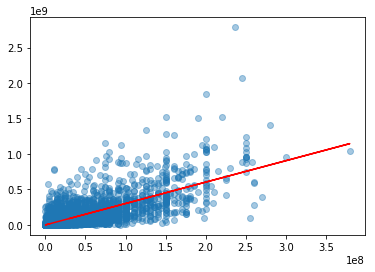

In [20]:
plt.scatter(x_dados,y_dados, alpha=0.4)
plt.plot(x_dados, ypredict, color='red')
plt.show()

### Análise de resíduos

Ao analisar os gráficos abaixo, é possível observar que os residuos nao se distribuem normalmente e tem um sigma2 variavel, uma vez que a variancia dos residuos esta crescendo conforme y aumenta, indicando a nao homocedasticidade suposta pelo modelo de regressao

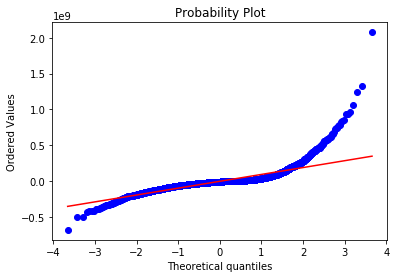

In [21]:
stats.probplot(results.resid, dist='norm', plot=plt);

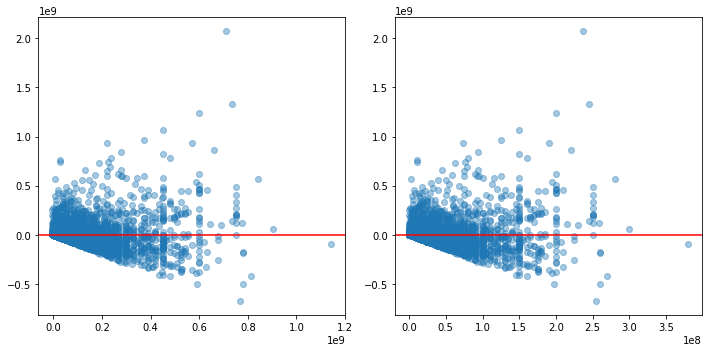

In [22]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(ypredict, results.resid,alpha=0.4);
plt.axhline(y=0,color='r',linestyle='-'); 

plt.subplot(122)
plt.scatter(x_dados, results.resid, alpha=0.4);
plt.axhline(y=0,color='r',linestyle='-'); 

plt.tight_layout()
plt.show()

## Conclusão do modelo de Regressão Linear simples

A conclusão do ajuste anterior é que as suposições de normalidade
(via teste de hipóteses) e de homocedasticidade (graficamente) não
estão válidas.
Logo, o modelo ajustado que relaciona como a receita de um filme  pode ser explicado pelo orçamento **não** deve ser considerado para
tomada de decisões.

## Regressão Linear Múltipla

Diferentemente da Regressão Linear Simples, é possível descrever as relacoes entre multiplas variáveis. No entanto, assim como na sua versao mais simples, este modelo precisa de variaveis quantitativas como entrada. Desta forma, vamos aplicar o modelo em dois contextos, utilizando apenas as variáveis quantitativas e utilizando todas as variáveis que considerarmos relevantes, para enfim termos uma conclusao do modelo.

Removemos as variáveis 
* **adult** - Os filmes considerados adultos correspondiam a uma parte muito pequena da amostra e portanto essa variavel nao iria refletir na nossa analise
* homepage - nao 
* original_title, poster_path, imdb_id e video não trazem informacoes que possam ser usadas em nosso modelo de predicao
* status - como queremos prever a receita de um filme, iremos analisar apenas os filmes que já foram lançados, que correspondem a maior parte do dataset


Podemos transformar em tem ou nao tem :



As variáveis que consideramos relevantes, em um primeiro momento, para prever a receita de um filme sao:

* belongs_to_collection     object
* budget                     int64
* genres                    object
* original_language         object
* overview                  object
* popularity                object
* production_companies      object
* production_countries      object
* release_date              object
* revenue                  float64
* runtime                  float64
* spoken_languages          object
* tagline                   object
* title                     object
* vote_average             float64
* vote_count               float64



Primeiro vamos separar a variavel de release_date  em ano e semana do ano para add a regressao

In [23]:
date = pd.to_datetime(metadados.loc[:,'release_date'].astype(str))
year = date.dt.year
week = date.dt.week
month = date.dt.month
metadados.loc[:,'year'] = year
metadados.loc[:,'week'] = week
metadados.loc[:,'month'] = month

Abaixo transformamos a variavel belongs_to_collection em uma variavel booleana . Sendo assim, temos:
* **0** - significa que o filme nao pertence a nenhuma colecao
* **1** - significa que o filme pertence a uma colecao

In [24]:
metadados['belongs_to_collection'] = metadados['belongs_to_collection'].replace(np.nan, 0)
filtra_collection = metadados.belongs_to_collection != 0
metadados.loc[filtra_collection,'belongs_to_collection'] = 1

Preparadas a variaveis quantitativas, vamos separa-las a partir da base metadados

In [25]:
met = metadados[['title', 'budget', 'runtime', 'revenue', 'vote_average', 'vote_count', 'popularity', 'year', 'week','month','belongs_to_collection']]#.set_index('title')
met.describe()

,budget,runtime,revenue,vote_average,vote_count,year,week,month,belongs_to_collection
count,4.546300e+04,45203.000000,4.546000e+04,45460.000000,45460.000000,45376.000000,45376.000000,45376.000000,45463.000000
mean,4.224579e+06,94.128199,1.120935e+07,5.618207,109.897338,1991.881193,27.513157,6.459075,0.098784
std,1.742413e+07,38.407810,6.433225e+07,1.924216,491.310374,24.055360,15.956942,3.628160,0.298375
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1874.000000,1.000000,1.000000,0.000000
25%,0.000000e+00,85.000000,0.000000e+00,5.000000,3.000000,1978.000000,13.000000,3.000000,0.000000
50%,0.000000e+00,95.000000,0.000000e+00,6.000000,10.000000,2001.000000,29.000000,7.000000,0.000000
75%,0.000000e+00,107.000000,0.000000e+00,6.800000,34.000000,2010.000000,41.000000,10.000000,0.000000
max,3.800000e+08,1256.000000,2.787965e+09,10.000000,14075.000000,2020.000000,53.000000,12.000000,1.000000


In [26]:
# definindo as variaveis quanti a serem utilizadas
met['popularity'] = met['popularity'].astype('float')
quant = ['budget', 'runtime', 'revenue', 'vote_average', 'vote_count', 'popularity', 'year', 'week', 'month']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
met = met.loc[:,quant].replace(0, np.nan).dropna()
met['belongs_to_collection'] = metadados['belongs_to_collection']

In [28]:
met

,budget,runtime,revenue,vote_average,vote_count,popularity,year,week,month,belongs_to_collection
0,30000000.0,81.0,373554033.0,7.7,5415.0,21.946943,1995.0,44.0,10.0,1
1,65000000.0,104.0,262797249.0,6.9,2413.0,17.015539,1995.0,50.0,12.0,0
3,16000000.0,127.0,81452156.0,6.1,34.0,3.859495,1995.0,51.0,12.0,0
5,60000000.0,170.0,187436818.0,7.7,1886.0,17.924927,1995.0,50.0,12.0,0
8,35000000.0,106.0,64350171.0,5.5,174.0,5.231580,1995.0,51.0,12.0,0
9,58000000.0,130.0,352194034.0,6.6,1194.0,14.686036,1995.0,46.0,11.0,1
10,62000000.0,106.0,107879496.0,6.5,199.0,6.318445,1995.0,46.0,11.0,0
13,44000000.0,192.0,13681765.0,7.1,72.0,5.092000,1995.0,51.0,12.0,0
14,98000000.0,119.0,10017322.0,5.7,137.0,7.284477,1995.0,51.0,12.0,0
15,52000000.0,178.0,116112375.0,7.8,1343.0,10.137389,1995.0,47.0,11.0,0


In [29]:
quant_x = quant.copy()
quant_x.append('belongs_to_collection')
quant_x.remove('revenue')
quant_x

['budget',
 'runtime',
 'vote_average',
 'vote_count',
 'popularity',
 'year',
 'week',
 'month',
 'belongs_to_collection']

In [30]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [31]:
#definindo as variaveis explicativas e dependentes, e garantindo que todos estejam em formato de float
X = met.loc[:, quant_x].astype(float)
Y = met.revenue.astype(float)

results = regress(X,Y)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     1622.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:09:51   Log-Likelihood:            -1.0558e+05
No. Observations:                5362   AIC:                         2.112e+05
Df Residuals:                    5352   BIC:                         2.112e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.686e+08    1.6e+08      4.799      0.000    4.55e+08    1.08e+09
budget                    1.7443      0.039     45.063      0.000       1.668       1.820
runtime                1.193e+05   6.01e+04      1.985      0.047    1500.739    2.37e+05
vote_average           1.397e+06   1.56e+06      0.894      0.371   -1.66e+06    4.46e+06
vote_count             6.055e+04   1396.506     43.357      0.000    5.78e+04    6.33e+04
popularity              9.07e+05   9.71e+04      9.337      0.000    7.17e+05     1.1e+06
year                  -4.102e+05    7.9e+04     -5.194      0.000   -5.65e+05   -2.55e+05
week                   1.624e+05   3.53e+05      0.461      0.645   -5.29e+05    8.53e+05
month                 -4.312e+05   1.54e+06     -0.281      0.779   -3.44e+06    2.58e+06
belongs_to_collection  4.778e+07   2.99e+06     15.983      0.000    4.19e+07    5.36e+07
==============================================================================
Omnibus:                     3941.876   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           286992.642
Skew:                           2.866   Prob(JB):                         0.00
Kurtosis:                      38.379   Cond. No.                     6.92e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.92e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Para selecionar as variáveis mais significantes para o nosso modelo, utilizamos o método Stepwise. O código da função stepwise_selection abaixo foi obtido através deste link (https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447)

In [143]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, Y)

print('resulting features:')
print(result)

Add  budget                         with p-value 0.0
Add  vote_count                     with p-value 0.0
Add  belongs_to_collection          with p-value 8.38964e-59
Add  popularity                     with p-value 5.87684e-20
Add  year                           with p-value 6.01386e-09
Add  runtime                        with p-value 0.0139304
resulting features:
['budget', 'vote_count', 'belongs_to_collection', 'popularity', 'year', 'runtime']


A partir do resultado acima, temos como significantes as variáveis 'vote_count', 'budget', 'year' e 'popularity'. Vale ressaltar que é de certa forma incorreto prever a receita de um filme utilizando as variáveis de popularidade e numero de votos, mesmo que sejam significantes e bem correlacionados com a receita, uma vez que esses dados só são possíveis após o lancamento do filme.

### Com as variáveis quali

Para conseguirmos utilizar as variáveis quali em uma regressao linear, é preciso encodar elas. Para isso, vamos aplicar a técnica ... As variáveis a serem utilizadas sao:

* a list of film genres
* release date — split up into year and day of the year
* a list of spoken languages
* runtime
* a list of production companies
* a list of cast members
* a list of crew members
* keywords



We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

* Crew: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.
* Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.
* Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as Dogs and Dog are considered the same.

Para definirmos o tamanho do crew e do cast, utilizamos os passos do site ... que utiliza a biblioteca ... Primeiramente lemos os arquivos credits e keywords e juntamos ao df metadados principal. Assim, utilizamos tambem a funcao get_director, para selecionarmos o diretor do filme a partir da variavel cast, uma vez que os outros dados de cast sao pouco relevantes

In [33]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [34]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadados['id'] = metadados['id'].astype('int')

In [35]:

metadados = metadados.merge(credits, on='id')
metadados = metadados.merge(keywords, on='id')

In [36]:
metadados['cast'] = metadados['cast'].apply(literal_eval)
metadados['crew'] = metadados['crew'].apply(literal_eval)
metadados['keywords'] = metadados['keywords'].apply(literal_eval)

In [37]:
metadados['cast_size'] = metadados['cast'].apply(lambda x: len(x))
metadados['crew_size'] = metadados['crew'].apply(lambda x: len(x))

In [38]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [39]:
metadados['director'] = metadados['crew'].apply(get_director)

In [40]:
metadados['cast'] = metadados['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
metadados['cast'] = metadados['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [41]:
metadados['keywords'] = metadados['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [42]:
metadados['genres'] = metadados['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [43]:
metadados['production_companies'] = metadados['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [44]:
metadados['spoken_languages'] = metadados['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [45]:
metadados.dtypes

adult                     object
belongs_to_collection      int64
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
year                     float64
week                     float64
month                    float64
cast                      object
crew                      object
keywords                  object
cast_size 

In [46]:
metadados.spoken_languages

0                             [English]
1                   [English, Français]
2                             [English]
3                             [English]
4                             [English]
5                    [English, Español]
6                   [Français, English]
7                    [English, Deutsch]
8                             [English]
9           [English, Pусский, Español]
10                            [English]
11                   [English, Deutsch]
12                            [English]
13                            [English]
14                     [English, Latin]
15                            [English]
16                            [English]
17                            [English]
18                            [English]
19                            [English]
20                            [English]
21                   [English, Deutsch]
22       [English, Español, Nederlands]
23                            [English]
24                            [English]


Feito isso, vamos filtrar os dados, removendo os Nan's e em seguida selecionaremos as variaveis qualitativas a serem dummificadas

In [47]:
s = metadados.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()

In [48]:
s

woman director          3128
independent film        1942
murder                  1314
based on novel           841
musical                  734
sex                      685
violence                 651
biography                641
nudity                   636
revenge                  626
suspense                 590
love                     574
female nudity            569
sport                    544
police                   461
sequel                   445
teenager                 441
duringcreditsstinger     440
friendship               423
world war ii             394
drug                     360
prison                   351
stand-up comedy          351
high school              319
martial arts             314
suicide                  312
film noir                311
silent film              306
kidnapping               306
rape                     306
                        ... 
tantra                     1
stalljunge                 1
white castle               1
colonial ameri

Como podemos observar, temos bastante palavras-chave com frequencia igual a um. Desta forma, ao removermos estas palavras, nao ira afetar no resultado final.

In [49]:
s = s[s > 1]
stemmer = SnowballStemmer('english')
metadados['keywords'] = metadados['keywords'].apply(filter_keywords)
metadados['keywords'] = metadados['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
metadados['keywords'] = metadados['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [50]:
#como nao vamos mais precisar das infos da coluna crew, podemos remove-la do df metadados
#metadados.drop(columns=['crew'])

In [51]:
# vamos definir os tipos de cada uma das variaveis
metadados['director'] = metadados['director'].astype('category')


In [52]:
quali = ['genres', 'original_language', 'original_title', 'overview', 'spoken_languages', 'keywords', 'director','cast' ]
#tagline precisa ser separada em palavras

In [105]:
#limpeza dos dados
var = ['budget', 'revenue', 'year','belongs_to_collection','genres','original_language']
met2 = metadados[var]


In [106]:
met2.loc[:,['budget', 'revenue', 'year']] = met2.loc[:,['budget', 'revenue', 'year']].replace(0, np.nan)
met2['belongs_to_collection'] = metadados['belongs_to_collection']
met2['genres'] = metadados['genres']
met2['original_language'] = metadados['original_language']

met2limpo = met2.dropna()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [107]:
met2limpo.index

Int64Index([    0,     1,     3,     5,     8,     9,    10,    13,    14,
               15,
            ...
            46019, 46133, 46177, 46302, 46330, 46413, 46561, 46571, 46574,
            46584],
           dtype='int64', length=5458)

In [109]:
met2limpo.reset_index(drop=True)

,budget,revenue,year,belongs_to_collection,genres,original_language
0,30000000.0,373554033.0,1995.0,1,"[Animation, Comedy, Family]",en
1,65000000.0,262797249.0,1995.0,0,"[Adventure, Fantasy, Family]",en
2,16000000.0,81452156.0,1995.0,0,"[Comedy, Drama, Romance]",en
3,60000000.0,187436818.0,1995.0,0,"[Action, Crime, Drama, Thriller]",en
4,35000000.0,64350171.0,1995.0,0,"[Action, Adventure, Thriller]",en
5,58000000.0,352194034.0,1995.0,1,"[Adventure, Action, Thriller]",en
6,62000000.0,107879496.0,1995.0,0,"[Comedy, Drama, Romance]",en
7,44000000.0,13681765.0,1995.0,0,"[History, Drama]",en
8,98000000.0,10017322.0,1995.0,0,"[Action, Adventure]",en
9,52000000.0,116112375.0,1995.0,0,"[Drama, Crime]",en


In [130]:
#analisando a variavel original language e como ela se distribui
linguastop = met2limpo.original_language.value_counts().head(20)
linguastop.index

Index(['en', 'hi', 'fr', 'ru', 'ja', 'es', 'it', 'zh', 'ta', 'ko', 'de', 'cn',
       'ml', 'da', 'sv', 'nl', 'te', 'pt', 'he', 'no'],
      dtype='object')

In [132]:
p = met2limpo.loc[met2limpo.original_language.isin(linguastop.index),:]

Para encodarmos a variavel original_language vamos selecionar as 20 linguas mais frequentes, o que é razoavel visto que corresponde a cerca de 99% do dataset. Desta forma conseguiremos rodar o codigo e add no modelo de regressao linear multipla.

#### encodando generos 
Para fazer isso criamos uma funcao que encoda uma variavel em forma de lista. Vale ressaltar aqui que testamos a funcao com outras variáveis, porém provavelmente por um numero muito grande de categorias o kernel morreu.

In [135]:
def encode_variable(data, col=[]):
    df=data
    for col in col:
        variable_df = pd.DataFrame(df[col].tolist())
        variable_obj = variable_df.stack()
        variable_df = pd.get_dummies(variable_obj)
        variable_df = variable_df.sum(level=0)
        variable_df = pd.concat([df,variable_df],axis=1, join='inner')
        df = variable_df
    #variable_df = pd.concat([data, df], axis=1)
    return variable_df

x = encode_variable(p, col=['genres','original_language'])

# com mais de uma variavel nao vai
x

,budget,revenue,year,belongs_to_collection,genres,original_language,Action,Adventure,Animation,Comedy,...,de,en,es,fr,it,ja,pt,ru,sv,zh
0,30000000.0,373554033.0,1995.0,1,"[Animation, Comedy, Family]",en,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,65000000.0,262797249.0,1995.0,0,"[Adventure, Fantasy, Family]",en,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,16000000.0,81452156.0,1995.0,0,"[Comedy, Drama, Romance]",en,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,60000000.0,187436818.0,1995.0,0,"[Action, Crime, Drama, Thriller]",en,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
8,35000000.0,64350171.0,1995.0,0,"[Action, Adventure, Thriller]",en,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
9,58000000.0,352194034.0,1995.0,1,"[Adventure, Action, Thriller]",en,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10,62000000.0,107879496.0,1995.0,0,"[Comedy, Drama, Romance]",en,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
13,44000000.0,13681765.0,1995.0,0,"[History, Drama]",en,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
14,98000000.0,10017322.0,1995.0,0,"[Action, Adventure]",en,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
15,52000000.0,116112375.0,1995.0,0,"[Drama, Crime]",en,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [139]:

Xq = x.loc[:,['budget', 'year', 'belongs_to_collection', 'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western','cn', 'da', 'de', 'en', 'es',
       'fr', 'it', 'ja', 'pt', 'ru', 'sv', 'zh'] ].astype(float)
Yq = x.revenue.astype(float)

In [140]:
Xq

,budget,year,belongs_to_collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,de,en,es,fr,it,ja,pt,ru,sv,zh
0,30000000.0,1995.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65000000.0,1995.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16000000.0,1995.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,60000000.0,1995.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,35000000.0,1995.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,58000000.0,1995.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,62000000.0,1995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,44000000.0,1995.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,98000000.0,1995.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,52000000.0,1995.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
results = regress(Xq,Yq)
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     10.68
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           1.93e-37
Time:                        17:35:10   Log-Likelihood:                -13230.
No. Observations:                 660   AIC:                         2.652e+04
Df Residuals:                     631   BIC:                         2.665e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.513e+09   5.91e+08      2.562      0.011    3.53e+08    2.67e+09
budget                    2.7650      0.199     13.909      0.000       2.375       3.155
year                  -8.389e+05   3.35e+05     -2.504      0.013    -1.5e+06   -1.81e+05
belongs_to_collection  7.407e+07   1.16e+07      6.369      0.000    5.12e+07    9.69e+07
Action                 1.561e+07   1.37e+07      1.138      0.256   -1.13e+07    4.26e+07
Adventure             -3.743e+06   1.49e+07     -0.252      0.801   -3.29e+07    2.55e+07
Animation             -2.486e+07   2.93e+07     -0.848      0.397   -8.24e+07    3.27e+07
Comedy                -1.341e+07   1.29e+07     -1.039      0.299   -3.88e+07    1.19e+07
Crime                 -2.193e+07   1.42e+07     -1.544      0.123   -4.98e+07    5.96e+06
Documentary           -5.488e+07   1.27e+08     -0.433      0.665   -3.04e+08    1.94e+08
Drama                  5.924e+06   1.23e+07      0.481      0.631   -1.83e+07    3.01e+07
Family                 -8.61e+06   2.19e+07     -0.392      0.695   -5.17e+07    3.45e+07
Fantasy               -8.824e+06   1.82e+07     -0.484      0.629   -4.46e+07     2.7e+07
Foreign                6.926e-07   2.91e-07      2.378      0.018    1.21e-07    1.26e-06
History               -3.431e+07   2.64e+07     -1.301      0.194   -8.61e+07    1.75e+07
Horror                 1.769e+06   1.83e+07      0.096      0.923   -3.42e+07    3.78e+07
Music                  1.407e+07   2.87e+07      0.490      0.624   -4.23e+07    7.04e+07
Mystery                1.017e+06   1.89e+07      0.054      0.957   -3.61e+07    3.82e+07
Romance               -1.673e+07   1.33e+07     -1.258      0.209   -4.28e+07    9.38e+06
Science Fiction       -2.505e+07   1.57e+07     -1.596      0.111   -5.59e+07    5.77e+06
TV Movie               5.597e-08   7.77e-08      0.720      0.472   -9.67e-08    2.09e-07
Thriller              -1.255e+07   1.34e+07     -0.937      0.349   -3.89e+07    1.38e+07
War                   -3.297e+07   2.71e+07     -1.218      0.224   -8.61e+07    2.02e+07
Western               -1.441e+06    3.6e+07     -0.040      0.968   -7.21e+07    6.92e+07
cn                     1.589e+08   1.04e+08      1.535      0.125   -4.45e+07    3.62e+08
da                    -1.839e-08   2.35e-08     -0.783      0.434   -6.45e-08    2.77e-08
de                      1.75e+08   1.41e+08      1.241      0.215   -1.02e+08    4.52e+08
en                     1.761e+08   7.93e+07      2.221      0.027    2.04e+07    3.32e+08
es                      1.75e+08   9.54e+07      1.834      0.067   -1.24e+07    3.62e+08
fr                      1.76e+08   9.15e+07      1.925      0.055   -3.58e+06    3.56e+08
it                     2.769e+08   1.14e+08      2.439      0.015     5.4e+07       5e+08
ja                     

In [144]:
result2 = stepwise_selection(Xq, Yq)

print('resulting features:')
print(result2)

Add  budget                         with p-value 7.94006e-44
Add  belongs_to_collection          with p-value 5.92864e-10
Add  year                           with p-value 0.00689414
resulting features:
['budget', 'belongs_to_collection', 'year']


In [60]:
#director vai ser usado no random forest regressor
metadados.director.astype('category').cat.codes

0         8138
1         7891
2         6406
3         5002
4         2547
5        11408
6        15795
7        13026
8        13030
9        10797
10       13946
11       11201
12       15258
13       12391
14       13658
15       10837
16        1033
17         695
18       15552
19        8544
20        1552
21        8297
22       13757
23       16774
24       11644
25       12387
26        9860
27       14284
28        7415
29       17476
         ...  
46598    16654
46599     1735
46600     4054
46601    13637
46602     4236
46603     9627
46604     5541
46605     5541
46606     5541
46607     5541
46608     5541
46609     5541
46610     5541
46611    14789
46612     5541
46613     5541
46614    14048
46615    13568
46616    15069
46617    12561
46618     7354
46619     1625
46620     1625
46621       43
46622     8116
46623     6046
46624     9699
46625    10682
46626    17238
46627     3246
Length: 46628, dtype: int16

In [61]:
metadados.original_language.value_counts().head(20).sum()

45365

In [108]:
met2limpo.reset_index(drop=True)


,budget,revenue,year,belongs_to_collection,genres,original_language
0,30000000.0,373554033.0,1995.0,1,"[Animation, Comedy, Family]",en
1,65000000.0,262797249.0,1995.0,0,"[Adventure, Fantasy, Family]",en
2,16000000.0,81452156.0,1995.0,0,"[Comedy, Drama, Romance]",en
3,60000000.0,187436818.0,1995.0,0,"[Action, Crime, Drama, Thriller]",en
4,35000000.0,64350171.0,1995.0,0,"[Action, Adventure, Thriller]",en
5,58000000.0,352194034.0,1995.0,1,"[Adventure, Action, Thriller]",en
6,62000000.0,107879496.0,1995.0,0,"[Comedy, Drama, Romance]",en
7,44000000.0,13681765.0,1995.0,0,"[History, Drama]",en
8,98000000.0,10017322.0,1995.0,0,"[Action, Adventure]",en
9,52000000.0,116112375.0,1995.0,0,"[Drama, Crime]",en


https://medium.com/@CMpoi/a-quick-tutorial-to-encode-list-variables-125ba4040325